In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
pi, sin, cos = np.pi, np.sin, np.cos

In [2]:
def ramp(t_star):
    if t_star>=0.0 and t_star<0.1:
        return t_star*10.
    elif t_star>=0.1 and t_star<0.9:
        return 1.
    elif t_star>=0.9 and t_star<=1.:
        return (1.-t_star)*10.
    else:
        return 0.

In [3]:
def get_sub_fldrs(path):
    folders = []
    for folder in os.listdir(path):
        if os.path.isdir(
            os.path.join(path, folder)
        ):
            # Get absolute path of folder
            abs_path = os.path.abspath(os.path.join(path, folder))
            folders.append(abs_path)
    return folders

def get_opts_from_fldr(fname, custom=False):
    """
    Given a folder name of the form:
        'scheme_name_re_1e-3_mu_1e-3'
    return a dictionary of the form:
        {'scheme': 'name', 're': '1e-3', 'mu': '1e-3'}
    """
    fname = os.path.basename(fname)
    opts = {}
    if custom:
        temp = fname.split('_')
        # All even indices are keys, and all odd indices are values
        for i in range(0, len(temp), 2):
            opts[temp[i]] = temp[i+1]
    else:
        expected_keys = ['nx', 're', 'tf']
        # Look for expected keys
        for key in expected_keys:
            # Split the string at the key, and take the second element
            try:
                opts[key] = fname.split(key+'_')[1].split('_')[0]
            except Exception:
                pass
            # if key in fname:
            #     opts[key] = fname.split(key)[1].split('_')[1]
    return opts

def get_master_dict(main_dict):
    """
    Given a list of dictionaries, return a dictionary of the form:
        {'key1': [val1, val2, ...], 'key2': [val1, val2, ...], ...}
    """
    master_dict = {}
    for d in main_dict:
        for key, val in d.items():
            if key not in master_dict:
                master_dict[key] = [val]
            else:
                master_dict[key].append(val)
    # Remove duplicate values
    for key, val in master_dict.items():
        master_dict[key] = list(set(val))
        
    return master_dict
    
def get_results_file(path):
    for file in os.listdir(path):
        if file.endswith('results.npz'):
            return os.path.join(path, file)

def select_subfolder(subfolders, custom=False, **kwargs):
    """
    Given a list of subfolders, and a dictionary of the form:
        {'key1': val1, 'key2': val2, ...}
    return a list of subfolders that match the criteria.
    Example:
        select_subfolder(folders, re='100')
    """
    if len(kwargs) == 0:
        return subfolders

    # Make a copy of subfolders
    selected = subfolders.copy()
    # Loop over all keys in kwargs
    for key, val in kwargs.items():
        if len(selected) == 0:
            return []
        # Remove folders that don't match the criteria
        for fldr in subfolders:
            # tf = os.path.basename(fldr)
            opts = get_opts_from_fldr(fldr, custom)
            # print(tf)
            # print(opts)
            if key not in opts.keys() and (fldr in selected):
                selected.remove(fldr)
            else:
                if opts[key] != val and (fldr in selected):
                    selected.remove(fldr)
    return selected

In [37]:
def plotter(
    parent_dir, plot_type, ylim=None, custom=False, exact=False,
    plt_ramp=False, ramp_a=1.3,
    **kwargs
):
    plot_types = ['decay', 'l1', 'linf', 'p_l1', 'ke']
    if plot_type not in plot_types:
        raise ValueError(
            f'Invalid plot type: {plot_type}. Valid types are: {plot_types}'
        )
    subfolders = get_sub_fldrs(parent_dir)
    subfolders = select_subfolder(subfolders, custom, **kwargs)
    
    plot_exact = exact
    plt.figure(figsize=(8, 6))
    for folder in subfolders:
        results_file = get_results_file(folder)
        if results_file:
            data = np.load(results_file)
            t = data['t']
            plt_label = os.path.basename(folder)
            
            if plot_type == 'decay':
                if plot_exact:
                    plt.semilogy(t, data['decay_ex'], 'k--', label='Exact')
                    plot_exact = False
                plt.semilogy(t, data['decay'], label=plt_label)
            elif plot_type == 'l1':
                plt.plot(t, data['l1'], label=plt_label)
            elif plot_type == 'linf':
                plt.plot(t, data['linf'], label=plt_label)
            elif plot_type == 'p_l1':
                plt.plot(t, data['p_l1'], label=plt_label)
            elif plot_type == 'ke':
                if plot_exact:
                    plt.plot(t, data['ke_ex'], 'k--', label='Exact')
                    plot_exact = False
                plt.plot(t, data['ke'], label=plt_label)
    
    plot_exact = exact
    plot_ramp = plt_ramp
    for folder in subfolders:
        results_file = get_results_file(folder)
        if results_file:
            data = np.load(results_file)
            t = data['t']

            if plot_ramp:
                _t = np.linspace(0, t[-1], 700)
                f = [ramp(i) for i in _t]
                f = np.array(f)*ramp_a
                label = 'External force'
                if ramp_a == 1.3:
                    label += ' (Exact)'
                else:
                    label += ' (Trendline)'
                plt.plot(_t, f, 'k--', label=label)
                plot_ramp = False

            if plot_type == 'ke':
                if plot_exact:
                    maxima = argrelextrema(data['ke_ex'], np.greater)
                    if len(maxima[0]) > 0:
                        plt.plot(t[maxima], data['ke_ex'][maxima], 'o')
                        plot_exact = False

                # Plot local maximas as dots
                maxima = argrelextrema(data['ke'], np.greater)
                if len(maxima[0]) > 0:
                    plt.plot(t[maxima], data['ke'][maxima], 'o')

    
    if plot_type == 'ke':
        plt.ylim(0, 0.4)

    if ylim:
        plt.ylim(ylim)

    # Title is the keys=values in kwargs
    title = plot_type
    for key, val in kwargs.items():
        title += f" ({key}={val}) "

    plt.grid()
    plt.title(title)
    plt.xlabel('t')
    plt.legend()
    plt.show()

In [38]:
# fdir = 'outputs/tgv_basic_scheme_comparison'
fdir = 'outputs/tgv_ext_force_scheme_comparison'

fldrs = get_sub_fldrs(fdir)
temp = [get_opts_from_fldr(fldr) for fldr in fldrs]
master_dict = get_master_dict(temp)
master_dict

{'nx': ['100', '200'], 're': ['10000', '100000'], 'tf': ['3.0']}

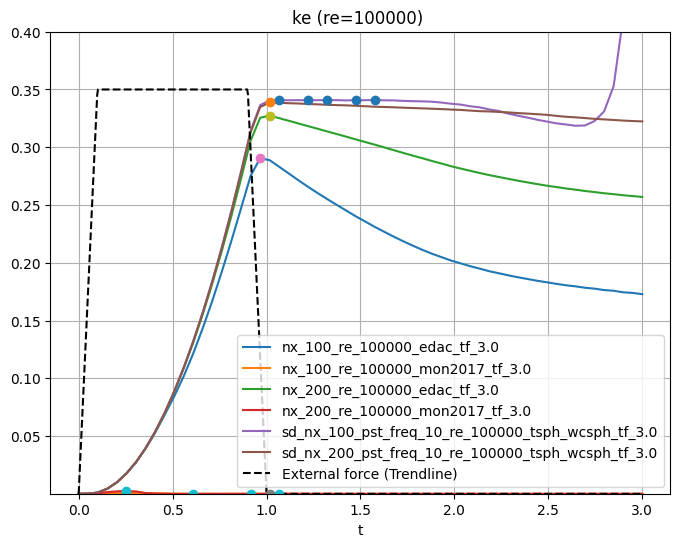

In [69]:
# plotter(fdir, 'ke', exact=1, ylim=(0.23, .26), re=str(50_000))
plotter(
    fdir, 'ke', plt_ramp=1, ramp_a=0.35, ylim=(1e-4, 0.4),
    # nx=str(100), 
    re=str(100_000),
)